# Results on the UCR Time Series Anomaly Detection datasets 

In [6]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

import pandas as pd
import os
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from model_trainer.entities import ANOMALY_ARCHIVE_ENTITIES, ANOMALY_ARCHIVE_ENTITY_TO_DATA_FAMILY
from model_selection.rank_aggregation import trimmed_kemeny, kemeny, borda, trimmed_borda

from sklearn.metrics import ndcg_score
from tqdm import tqdm 
from datetime import datetime

import matplotlib
import matplotlib.font_manager
from pprint import pprint
from mallows import mallows_kendall as mk

# matplotlib.rcParams['font.family'] = 'sans-serif'
# matplotlib.rcParams['font.sans-serif'] = 'Arial'

import sys
sys.path.append('/home/ubuntu/PyMAD/')
from src.pymad.evaluation.numpy import adjusted_precision_recall_f1_auc

In [5]:
# Path to saved ranking objects
split = 'test' # Which data split are the models evaluated on
metric = 'influence'
aggregation_type = 'borda'
overwrite = True

if split == 'train': SAVE_DIR = '/home/ubuntu/efs/results_Jul22_f1_train_set/' # NOTE: Pay careful attention to the paths here
elif split == 'test': SAVE_DIR = '/home/ubuntu/efs/results_Jul22_f1_test_set/' # NOTE: Pay careful attention to the paths here
SAVE_DIR_TEST = '/home/ubuntu/efs/results_Jul22_f1_test_set/'

# if split == 'train': SAVE_DIR = '/home/ubuntu/efs/results_Jul20_prauc/' # NOTE: Pay careful attention to the paths here
# elif split == 'test': SAVE_DIR = '/home/ubuntu/efs/results_Jul20_prauc/' # NOTE: Pay careful attention to the paths here
# SAVE_DIR_TEST = '/home/ubuntu/efs/results_Jul20_prauc/'

dataset = 'anomaly_archive'
FORECASTING_METRIC_NAMES = ['MAE', 'MSE', 'SMAPE', 'MAPE', 'LIKELIHOOD']
SYNTHETIC_METRIC_NAMES = ['wander', 'average', 'spikes', 'contextual', 'flip', 'speedup', 'scale', 'cutoff']

In [3]:
ranking_object_files = os.listdir(os.path.join(SAVE_DIR, dataset))
evaluated_entities = ['_'.join(i.split('_')[2:]).split('.')[0] for i in ranking_object_files]
ranking_object_files_test = os.listdir(os.path.join(SAVE_DIR_TEST, dataset))
evaluated_entities_test = ['_'.join(i.split('_')[2:]).split('.')[0] for i in ranking_object_files_test]

ranking_object_files = np.intersect1d(ranking_object_files, ranking_object_files_test)
evaluated_entities = np.intersect1d(evaluated_entities_test, evaluated_entities)

print(f'{len(evaluated_entities)} entities evaluated')
# print(f'Evaluated entities: {evaluated_entities}')

235 entities evaluated


In [18]:
PATH_TO_STATS_PKL = os.path.join(SAVE_DIR, f'stats_{dataset}_{split}_{metric}_{aggregation_type}.pkl') if metric == 'influence' else os.path.join(SAVE_DIR, f'stats_{dataset}_{split}_{metric}.pkl')

if not overwrite and os.path.exists(PATH_TO_STATS_PKL):
    with open(PATH_TO_STATS_PKL ,'rb') as f: 
        stats = pkl.load(f)
else:
    stats = {}

    for entity in tqdm(evaluated_entities): 
        ranking_obj_file = f'ranking_obj_{entity}.data'
        
        with open(os.path.join(SAVE_DIR, dataset, ranking_obj_file), 'rb') as f: 
            ranking_obj = pkl.load(f)
        
        # NOTE: Also open the test set to access PR-AUC and Best F-1
        with open(os.path.join(SAVE_DIR_TEST, dataset, ranking_obj_file), 'rb') as f: 
            ranking_obj_test = pkl.load(f)
    
        ranks = ranking_obj.ranks_by_metrics.astype(int)[1:, :]
        rank_prauc = ranking_obj_test.rank_prauc.astype(int)
        rank_f1 = ranking_obj_test.rank_f1.astype(int)

        if ranks.shape[1] != 19: print(f'Only {ranks.shape[1]} models trained on {entity}! Skipping...', ); continue 

        # Get metric names
        metric_names = list(ranking_obj.models_performance_matrix.columns)
        metric_names.remove('PR-AUC')
        metric_names.remove('Best F-1')

        # Perform rank aggregation
        _, trimmed_kemeny_rank = trimmed_kemeny(ranks, metric=metric, aggregation_type='kemeny', verbose=False)
        trimmed_kemeny_rank = trimmed_kemeny_rank.astype(int)
        _, kemeny_rank = kemeny(ranks, verbose=False)
        kemeny_rank = kemeny_rank.astype(int)

        _, trimmed_borda_rank = trimmed_borda(ranks, metric=metric, aggregation_type='borda')
        trimmed_borda_rank = trimmed_borda_rank.astype(int)
        
        r = ranks[:5, :].astype(float).copy()
        x, y = np.where((r > 0))
        for x_i, y_i in zip(x, y): r[x_i, y_i] = np.NaN
        borda_rank = np.clip(mk.borda_partial(r, w=1, k=1).astype(int), a_max=18, a_min=0) 
        # _, borda_rank = borda(ranks)
        borda_rank = borda_rank.astype(int)
        
        praucs = ranking_obj_test.models_performance_matrix.iloc[:, 0].to_numpy().squeeze()
        f1s = ranking_obj_test.models_performance_matrix.iloc[:, 1].to_numpy().squeeze()
        model_names = np.array(list(ranking_obj.models_performance_matrix.index))
        
        if np.std(praucs) == 0.0: continue # Bad datasets have 0.5 prauc for all models
                
        s = {
            'Rank by PR-AUC': model_names[rank_prauc], 
            'Rank by Best F-1': model_names[rank_f1],
            'Trimmed Kemeny rank': trimmed_kemeny_rank,
            'Trimmed Kemeny PR-AUCs': praucs[trimmed_kemeny_rank],
            'Trimmed Kemeny Best F-1': f1s[trimmed_kemeny_rank],
            'Kemeny rank': kemeny_rank,
            'Kemeny PR-AUCs': praucs[kemeny_rank],
            'Kemeny Best F-1': f1s[kemeny_rank],
            'Borda rank': borda_rank,
            'Borda PR-AUCs': praucs[borda_rank],
            'Borda Best F-1': f1s[borda_rank],
            'Trimmed Borda rank': trimmed_borda_rank,
            'Trimmed Borda PR-AUCs': praucs[trimmed_borda_rank],
            'Trimmed Borda Best F-1': f1s[trimmed_borda_rank],
            'Max PR-AUC': np.max(praucs),
            'Max Best F-1': np.max(f1s),
            'PR-AUCs': praucs,
            'Best F-1': f1s,
        }

        for i, mn in enumerate(metric_names):
            s[f'Predicted PR-AUCs ({mn})'] = praucs[ranks[i, :]]
            s[f'Predicted Best F-1 ({mn})'] = f1s[ranks[i, :]]

        stats[entity] = s

    with open(PATH_TO_STATS_PKL ,'wb') as f: 
        pkl.dump(stats, f)

  0%|          | 0/235 [00:01<?, ?it/s]


IndexError: index 5 is out of bounds for axis 0 with size 5

In [16]:
# Look at all anomaly archive data families
data_families = ['All Entities']
data_families.extend(sorted(list(set(list(ANOMALY_ARCHIVE_ENTITY_TO_DATA_FAMILY.values())))))
pprint(f'Data families: {data_families}') 

("Data families: ['All Entities', 'Acceleration Sensor Data', 'Accelerometer', "
 "'Air Temperature', 'Atrial Blood Pressure (ABP)', 'Electrocardiogram (ECG) "
 "Arrhythmia', 'Gait', 'Insect Electrical Penetration Graph (EPG)', 'NASA "
 "Data', 'Pig Atrial Blood Pressure', 'Power Demand', 'Respiration Rate "
 "(RESP)']")


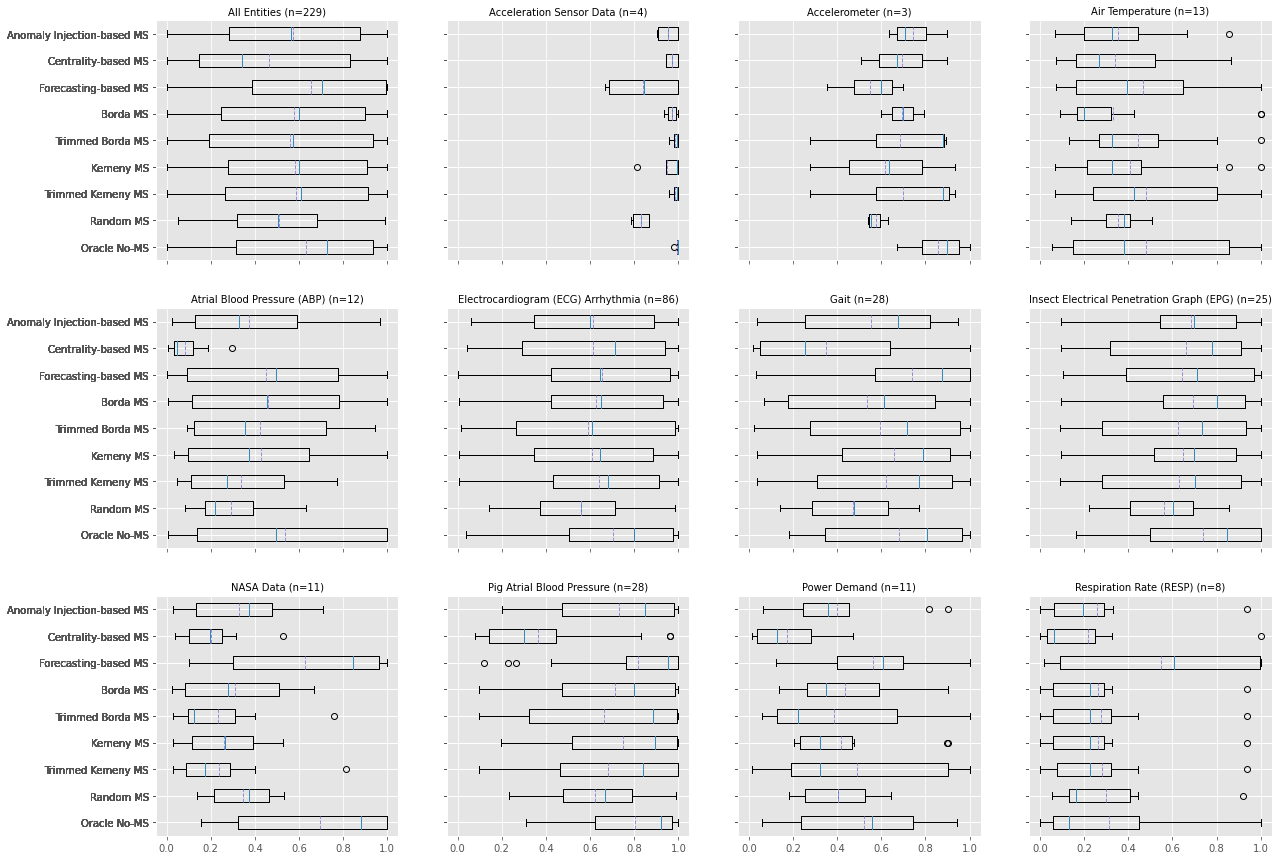

In [17]:
plt.style.use('ggplot')
fig, axes = plt.subplots(3, 4, figsize=(20, 15), sharey=True, sharex=True)
axes = axes.flatten()
# plt.suptitle(f'%age of Best F-1 of Oracle with Model Selection', fontsize=16)

result_table = {}

for i, data_family in enumerate(data_families):
    aggregate_stats = {'Trimmed Kemeny MS': [], 
                        'Kemeny MS': [], 
                        'Trimmed Borda MS': [], 
                        'Borda MS': [], 
                        'Oracle MS': [], 
                        'Random MS': [], 
                        'Forecasting-based MS': [], 
                        'Centrality-based MS': [], 
                        'Anomaly Injection-based MS': [], 
                        'Oracle No-MS': []}

    # Let's find the model which performs the best on average
    F1S = []
    for entity in stats.keys():
        if (data_family != 'All Entities') and (ANOMALY_ARCHIVE_ENTITY_TO_DATA_FAMILY[entity] != data_family): continue
        # if ('DISTORTED' in entity) or ('NOISE' in entity): continue
        F1S.append(stats[entity]['Best F-1'])

    F1S = np.array(F1S)
    best_model_idx = np.argmax(np.mean(F1S, axis=0))

    for entity in stats.keys():
        if (data_family != 'All Entities') and (ANOMALY_ARCHIVE_ENTITY_TO_DATA_FAMILY[entity] != data_family): continue
        # if ('DISTORTED' in entity) or ('NOISE' in entity): continue
        aggregate_stats['Trimmed Kemeny MS'].append(stats[entity]['Trimmed Kemeny Best F-1'][0])
        aggregate_stats['Kemeny MS'].append(stats[entity]['Kemeny Best F-1'][0]) 
        aggregate_stats['Trimmed Borda MS'].append(stats[entity]['Trimmed Borda Best F-1'][0])
        aggregate_stats['Borda MS'].append(stats[entity]['Borda Best F-1'][0]) 
        aggregate_stats['Oracle MS'].append(stats[entity]['Max Best F-1'])
        aggregate_stats['Random MS'].append(np.mean(stats[entity]['Best F-1']))
        aggregate_stats['Oracle No-MS'].append(stats[entity]['Best F-1'][best_model_idx])
        # aggregate_stats['Trimmed Kemeny MS'].append(stats[entity]['Trimmed Kemeny PR-AUCs'][0])
        # aggregate_stats['Kemeny MS'].append(stats[entity]['Kemeny PR-AUCs'][0]) 
        # aggregate_stats['Trimmed Borda MS'].append(stats[entity]['Trimmed Borda PR-AUCs'][0])
        # aggregate_stats['Borda MS'].append(stats[entity]['Borda PR-AUCs'][0]) 
        # aggregate_stats['Oracle MS'].append(stats[entity]['Max PR-AUC'])
        # aggregate_stats['Random MS'].append(np.mean(stats[entity]['PR-AUCs']))
        # aggregate_stats['Oracle No-MS'].append(stats[entity]['PR-AUCs'][best_model_idx])
    
    # Compute Metric-wise performance
    for entity in stats.keys():
        if (data_family != 'All Entities') and (ANOMALY_ARCHIVE_ENTITY_TO_DATA_FAMILY[entity] != data_family): continue
        # if ('DISTORTED' in entity) or ('NOISE' in entity): continue
        _forecasting_f1 = [] 
        _centrality_f1 = []
        _synthetic_f1 = []
        
        for m in stats[entity].keys(): 
            if ('Predicted' in m) and ('F-1' in m): 
            # if ('Predicted' in m) and ('PR-AUC' in m): 
                metric_class = m.split(' ')[-1][1:-1].split('_')[0]
                if metric_class == 'CENTRALITY': 
                    _centrality_f1.append(stats[entity][m][0])
                elif metric_class == 'SYNTHETIC': 
                    _synthetic_f1.append(stats[entity][m][0])
                elif metric_class in FORECASTING_METRIC_NAMES: 
                    _forecasting_f1.append(stats[entity][m][0])

        aggregate_stats['Forecasting-based MS'].append(_forecasting_f1)
        aggregate_stats['Centrality-based MS'].append(_centrality_f1)
        aggregate_stats['Anomaly Injection-based MS'].append(_synthetic_f1)

    for k, v in aggregate_stats.items():
        aggregate_stats[k] = np.array(v)
    
    aggregate_stats['Forecasting-based MS'] = np.median(aggregate_stats['Forecasting-based MS'], axis=1)
    aggregate_stats['Centrality-based MS'] = np.median(aggregate_stats['Centrality-based MS'], axis=1)
    aggregate_stats['Anomaly Injection-based MS'] = np.median(aggregate_stats['Anomaly Injection-based MS'], axis=1)

    # Compute ratios
    aggregate_stats['Oracle No-MS/Oracle MS'] = aggregate_stats['Oracle No-MS']/(aggregate_stats['Oracle MS'] + 1e-6)
    aggregate_stats['Random MS/Oracle MS'] = aggregate_stats['Random MS']/(aggregate_stats['Oracle MS'] + 1e-6)
    aggregate_stats['Trimmed Kemeny MS/Oracle MS'] = aggregate_stats['Trimmed Kemeny MS']/(aggregate_stats['Oracle MS'] + 1e-6)
    aggregate_stats['Kemeny MS/Oracle MS'] = aggregate_stats['Kemeny MS']/(aggregate_stats['Oracle MS'] + 1e-6)
    aggregate_stats['Trimmed Borda MS/Oracle MS'] = aggregate_stats['Trimmed Borda MS']/(aggregate_stats['Oracle MS'] + 1e-6)
    aggregate_stats['Borda MS/Oracle MS'] = aggregate_stats['Borda MS']/(aggregate_stats['Oracle MS'] + 1e-6)
    aggregate_stats['Forecasting-based MS/Oracle MS'] = aggregate_stats['Forecasting-based MS']/(aggregate_stats['Oracle MS'] + 1e-6)
    aggregate_stats['Centrality-based MS/Oracle MS'] = aggregate_stats['Centrality-based MS']/(aggregate_stats['Oracle MS'] + 1e-6)
    aggregate_stats['Anomaly Injection-based MS/Oracle MS'] = aggregate_stats['Anomaly Injection-based MS']/(aggregate_stats['Oracle MS'] + 1e-6)

    aggregate_stats['Oracle No-MS/Oracle MS'][aggregate_stats['Oracle No-MS/Oracle MS'] > 1] = 0
    aggregate_stats['Random MS/Oracle MS'][aggregate_stats['Random MS/Oracle MS'] > 1] = 0
    aggregate_stats['Trimmed Kemeny MS/Oracle MS'][aggregate_stats['Trimmed Kemeny MS/Oracle MS'] > 1] = 0
    aggregate_stats['Kemeny MS/Oracle MS'][aggregate_stats['Kemeny MS/Oracle MS'] > 1] = 0
    aggregate_stats['Trimmed Borda MS/Oracle MS'][aggregate_stats['Trimmed Borda MS/Oracle MS'] > 1] = 0
    aggregate_stats['Borda MS/Oracle MS'][aggregate_stats['Borda MS/Oracle MS'] > 1] = 0
    aggregate_stats['Forecasting-based MS/Oracle MS'][aggregate_stats['Forecasting-based MS/Oracle MS'] > 1] = 0
    aggregate_stats['Centrality-based MS/Oracle MS'][aggregate_stats['Centrality-based MS/Oracle MS'] > 1] = 0
    aggregate_stats['Anomaly Injection-based MS/Oracle MS'][aggregate_stats['Anomaly Injection-based MS/Oracle MS'] > 1] = 0

    axes[i].set_title(f"{data_family} (n={len(aggregate_stats['Oracle No-MS/Oracle MS'])})", fontsize=10)    
    _ = axes[i].boxplot([aggregate_stats['Oracle No-MS/Oracle MS'],
                        aggregate_stats['Random MS/Oracle MS'],
                        aggregate_stats['Trimmed Kemeny MS/Oracle MS'],
                        aggregate_stats['Kemeny MS/Oracle MS'],
                        aggregate_stats['Trimmed Borda MS/Oracle MS'],
                        aggregate_stats['Borda MS/Oracle MS'],
                        aggregate_stats['Forecasting-based MS/Oracle MS'],
                        aggregate_stats['Centrality-based MS/Oracle MS'],
                        aggregate_stats['Anomaly Injection-based MS/Oracle MS']
                        ], 
                    vert=False, 
                    bootstrap=10000,
                    showmeans=True,
                    meanline=True, 
                    labels = [
                        'Oracle No-MS', 
                        'Random MS', 
                        'Trimmed Kemeny MS', 
                        'Kemeny MS', 
                        'Trimmed Borda MS', 
                        'Borda MS', 
                        'Forecasting-based MS',
                        'Centrality-based MS',
                        'Anomaly Injection-based MS']
                    )

    result_table[data_family] = {
        'Oracle No-MS': np.median(aggregate_stats['Oracle No-MS/Oracle MS']),
        'Random MS': np.median(aggregate_stats['Random MS/Oracle MS']),
        'Trimmed Kemeny MS': np.median(aggregate_stats['Trimmed Kemeny MS/Oracle MS']),
        'Kemeny MS': np.median(aggregate_stats['Kemeny MS/Oracle MS']),
        'Trimmed Borda MS': np.median(aggregate_stats['Trimmed Borda MS/Oracle MS']),
        'Borda MS': np.median(aggregate_stats['Borda MS/Oracle MS']),
        'Forecasting-based MS': np.median(aggregate_stats['Forecasting-based MS/Oracle MS']),
        'Centrality-based MS': np.median(aggregate_stats['Centrality-based MS/Oracle MS']),
        'Anomaly Injection-based MS': np.median(aggregate_stats['Anomaly Injection-based MS/Oracle MS']),
    }

if metric == 'influence':
    plt.savefig(f"box_plot_{dataset}_{split}_{metric}_{aggregation_type}_{datetime.today().strftime(r'%H-%M-%m-%d-%Y')}.pdf", bbox_inches='tight')
else:
    plt.savefig(f"box_plot_{dataset}_{split}_{metric}_{datetime.today().strftime(r'%H-%M-%m-%d-%Y')}.pdf", bbox_inches='tight')
plt.show()

In [11]:
result_table = pd.DataFrame(result_table).T
result_table

,Oracle No-MS,Random MS,Trimmed Kemeny MS,Kemeny MS,Trimmed Borda MS,Borda MS,Forecasting-based MS,Centrality-based MS,Anomaly Injection-based MS
All Entities,0.724998,0.505497,0.604759,0.662743,0.604759,0.571427,0.720669,0.299400,0.571427
Acceleration Sensor Data,0.999999,0.831945,0.906918,0.992812,0.979611,0.972424,0.844971,0.973179,0.954557
Accelerometer,0.899997,0.553624,0.864404,0.633538,0.754096,0.424998,0.596936,0.596936,0.707690
Air Temperature,0.380951,0.380105,0.427270,0.327585,0.427270,0.276922,0.395832,0.269459,0.327272
Atrial Blood Pressure (ABP),0.495748,0.218877,0.300373,0.436080,0.290405,0.511136,0.494055,0.043075,0.285648
Electrocardiogram (ECG) Arrhythmia,0.798548,0.560534,0.717951,0.737323,0.676062,0.593386,0.651881,0.592047,0.604787
Gait,0.806716,0.474693,0.528634,0.792404,0.479654,0.825515,0.874999,0.134163,0.677487
Insect Electrical Penetration Graph (EPG),0.846149,0.602652,0.799999,0.699999,0.846149,0.848483,0.711859,0.652172,0.699999
NASA Data,0.879999,0.371712,0.316455,0.318839,0.230214,0.169696,0.846152,0.201550,0.373133
Pig Atrial Blood Pressure,0.920778,0.667543,0.932737,0.895519,0.951427,0.850107,0.984165,0.301060,0.849149


In [15]:
result_table = pd.DataFrame(result_table).T
result_table

,Oracle No-MS,Random MS,Trimmed Kemeny MS,Kemeny MS,Trimmed Borda MS,Borda MS,Forecasting-based MS,Centrality-based MS,Anomaly Injection-based MS
All Entities,0.724998,0.505497,0.611110,0.599998,0.571427,0.599998,0.703516,0.340424,0.562498
Acceleration Sensor Data,0.999999,0.831945,0.992812,0.992812,0.992812,0.972424,0.844971,0.973179,0.954557
Accelerometer,0.899997,0.553624,0.879308,0.633538,0.879308,0.698628,0.596936,0.671050,0.707690
Air Temperature,0.380951,0.380105,0.427270,0.327585,0.327585,0.199995,0.395832,0.269459,0.327272
Atrial Blood Pressure (ABP),0.495748,0.218877,0.276003,0.374113,0.356717,0.453057,0.494055,0.049274,0.329401
Electrocardiogram (ECG) Arrhythmia,0.798548,0.560534,0.680027,0.644822,0.609277,0.650932,0.644783,0.714244,0.597998
Gait,0.806716,0.474693,0.769155,0.787499,0.714989,0.611141,0.874999,0.256563,0.677487
Insect Electrical Penetration Graph (EPG),0.846149,0.602652,0.704057,0.699999,0.733329,0.799999,0.711534,0.777776,0.699999
NASA Data,0.879999,0.371712,0.174602,0.264461,0.123578,0.278480,0.846152,0.196969,0.373133
Pig Atrial Blood Pressure,0.920778,0.667543,0.838915,0.895519,0.883467,0.797561,0.954573,0.301060,0.849149


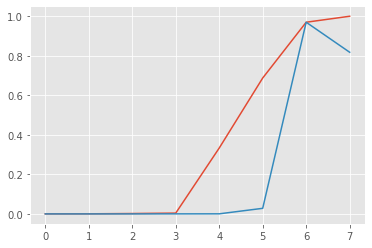

In [12]:
sorted_idxs = np.argsort(aggregate_stats['Oracle MS'])
plt.plot(aggregate_stats['Oracle MS'][sorted_idxs], label='Oracle MS')
plt.plot(aggregate_stats['Oracle No-MS'][sorted_idxs], label='Oracle No-MS')

### How does Best F-1 and PR-AUC of models correlate? 

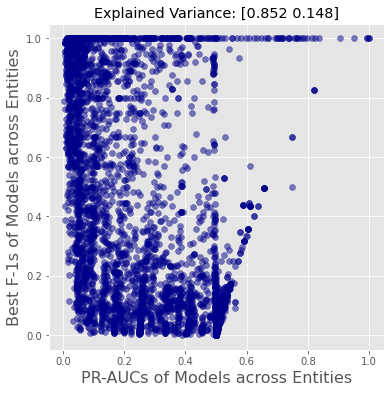

In [17]:
from sklearn.decomposition import PCA

### How does Best F-1 and PR-AUC of models correlate? 
F1S = []
PRAUCS = []
for entity in stats.keys():
    F1S.append(stats[entity]['Best F-1'])
    PRAUCS.append(stats[entity]['PR-AUCs'])
F1S = np.array(F1S).flatten()
PRAUCS = np.array(PRAUCS).flatten()

# Fit PCA to get the principal component of model quality
pca = PCA(n_components=2, whiten=True)
X = np.stack([F1S, PRAUCS], axis=1)
X_transform = pca.fit_transform(X)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title(f'Explained Variance: {np.around(pca.explained_variance_ratio_, 3)}')
ax.scatter(PRAUCS, F1S, alpha=0.5, color='darkblue')
ax.set_xlabel('PR-AUCs of Models across Entities', fontsize=16)
ax.set_ylabel('Best F-1s of Models across Entities', fontsize=16)
plt.savefig('scatter_plot_anomaly_archive_f1_vs_prauc.pdf')
plt.show()